# Homework №2

## Imports

In [1]:
import numba
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from rectools import Columns

### UsersKFoldPOut

Один из видов случайного разбиения является `KFold` по пользователям или объектам. Идея в том, чтобы разбить данные на `train` и `test` так, чтобы пользователи между ними не пересекались. Можно сказать, что это сочетание `Random + Warm start scenario`.

Если все данные обозначить как `[u1, u2, ..., uN]`, то для `KFold(k=3)`:
- Test: `[u1, ..,, u(N//3)]` Train: `[u(N//3 + 1), ..., uN]`
- Test: `[u(N//3 + 1), ..,, u(2*N//3)]` Train: `[u1, ..., u(N//3 + 1)] & [u(2*N//3 + 1), ..., uN]`
- Test: `[u(2*N//3 + 1), ..,, uN]` Train: `[u1, ..., u(2*N//3)]`

В начале преобразуем данные в pandas.DataFrame вида {user, item, order}, где order - порядковый номер с конца (0 - самый "свежий" лайк, чем больше order, тем позже был поставлен лайк)

In [2]:
def load_track_data(filename):
    total_items = []
    total_users = []
    total_orders = []
    df = pd.DataFrame()
    with open(filename) as file:
        for i, line in enumerate(file.readlines()):
            items = list(map(int, line.split()))
            order = np.arange(len(items))[::-1] 
            user = np.full(len(items), i) 
            total_orders.append(order)
            total_items.append(items)
            total_users.append(user)
    df[Columns.User] = np.hstack(total_users)
    df[Columns.Item] = np.hstack(total_items)
    df["order"] = np.hstack(total_orders)
    return df

Отсортируем датафрейм так, чтобы последние взаимодействия были в начале

In [3]:
df = load_track_data("tracks_data/test")
df = df.sort_values(["user_id", "order"])
df.head()

,user_id,item_id,order
19,0,471705,0
18,0,219426,1
17,0,101168,2
16,0,361110,3
15,0,22932,4


**Итоговая задача** - построить схему валидации для данного соревнования с учетом особенностей сорвенования
- Между `train` и `test` не должно быть общих пользователей
- Количество фолдов задается через параметр класса `n_folds`
- В `test` должно быть не более `p` последних треков (параметр класса `p`)

За основу возьмем класс **UsersKFold** и модифицируем его, добавив в конструктор следующие параметры:<br>
- **p** - кол-во последних треков<br>
- **order_column** - название колонки в датафрейме с порядком прослушиваний треков

In [4]:
class UsersKFoldPOut():
    def __init__(self, n_folds, p, user_column=Columns.User, order_column="order", random_seed=23):
        self.p = p
        self.n_folds = n_folds
        self.user_column = user_column
        self.order_column = order_column
        self.random_seed = random_seed
    
    def split(self, df):
        users = df[self.user_column].unique()
        users_count = len(users)
        
        np.random.seed(self.random_seed)
        np.random.shuffle(users)
        
        fold_sizes = np.full(self.n_folds, users_count // self.n_folds, dtype=int)
        fold_sizes[: users_count % self.n_folds] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_fold_users = users[start:stop]
            test_mask = df[self.user_column].isin(test_fold_users)
            train_mask = ~test_mask

            # Сделаем groupby по юзерам, и возьмем у каждого юзера только 
            # первые p треков, т.к. датафрейм уже отсортирован
            first_p = df.groupby(self.user_column)[self.order_column].head(self.p)
            # Проверяя вхождение индексов first_p в индексы df, получим дополнительную маску
            first_p_mask = df.index.isin(first_p.index)
            # И с её помощью обновим маску для теста
            test_mask &= first_p_mask
            current += fold_size

            yield train_mask, test_mask

In [5]:
cv = UsersKFoldPOut(n_folds=3, p=1)

for i, (train_mask, test_mask) in enumerate(cv.split(df)):
    train = df[train_mask]
    test = df[test_mask]
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')
    print(test.head())

Fold#0 | Train: 15516536, Test: 96638
      user_id  item_id  order
355         3   295397      0
610         4    60144      0
779         9   474140      0
923        10   469639      0
1242       12   332882      0
Fold#1 | Train: 15539176, Test: 96638
     user_id  item_id  order
274        1   116101      0
347        2   257988      0
648        5    91048      0
724        6   163765      0
740        7    65345      0
Fold#2 | Train: 15468688, Test: 96638
      user_id  item_id  order
19          0   471705      0
1178       11   345117      0
1400       13   382122      0
1475       15    42737      0
1730       16   436744      0


### pFound

Исходные данные - Yandex Cup 2022 Analytics
- Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать pFound
- Данные - https://yadi.sk/d/guqki4UI4hFlXQ

Загрузим в датафреймы все необходимые данные

In [6]:
hostid_url = pd.read_csv("open_task/hostid_url.tsv", sep="\t")
hostid_url.columns = ["hostid", "url"]
hostid_url

,hostid,url
0,1000,http://www.pozdravleniya.biz/stihi/detskie/
1,1001,http://www.pravda.ru/society/family/pbringing/...
2,1002,http://www.pravpiter.ru/gorn/n015/ta003.htm
3,1003,http://www.pregnancycalendar.ru/biblioteka/vse...
4,1004,http://www.preletenov.yc.cz/ekcat1/arnold-shva...
...,...,...
848,997,http://www.portalus.ru/modules/economics/rus_r...
849,997,http://www.portalus.ru/modules/economics/rus_r...
850,997,http://www.portalus.ru/modules/economics/rus_s...
851,998,http://www.poskart.ru/dobrij-prigoditsa.html


In [7]:
qid_query = pd.read_csv("open_task/qid_query.tsv", sep="\t")
qid_query.columns = ["qid", "query"]
qid_query

,qid,query
0,107538,Список белорусской литературы по лизингу
1,150126,написание review
2,168170,медаль в подарок на 30 лет
3,176370,что означает рожь и пшеница годом родится а ве...
4,192007,должностная инструкция главного технолога моло...
5,20860,в египетской мифологии богиня-львица
6,21070,теория Лаунхардта
7,213932,6 класс география почему в географическую обол...
8,221830,семья
9,242953,стихи про новый год для детей


In [8]:
qid_url_rating = pd.read_csv("open_task/qid_url_rating.tsv", sep="\t")
qid_url_rating.columns = ["qid", "url", "rating"]
qid_url_rating

,qid,url,rating
0,10387,http://bigtorrents.org/publ/batman_arkham_city...,0.14
1,10387,http://consolelife.ru/xbox-360/6577-o-rossiysk...,0.14
2,10387,http://dic.academic.ru/book.nsf/3662736/Batman...,0.00
3,10387,http://forum.csmania.ru/viewtopic.php?t=25986,0.14
4,10387,http://forum.igromania.ru/printthread.php?s=f3...,0.07
...,...,...,...
848,380923,http://www.spishy.ru/referats/14/8040,0.00
849,380923,http://www.sprinter.ru/books/1821345.html,0.00
850,380923,http://www.twirpx.com/files/mathematics/algebr...,0.00
851,380923,http://wzyocgeawwo.eklablog.com/2-a60036325,0.00


Объединим **qid_url_rating** с **hostid_url**, чтобы получить датафрейм вида **{query, host, rating}**

In [9]:
data = qid_url_rating.merge(hostid_url, on="url")
data = data.groupby(["qid", "hostid"])["rating"].max().reset_index()
data = data.sort_values(["qid", "rating"], ascending=[True, False])
data = data.rename({"rating": "pRel[i]"}, axis=1)
data

,qid,hostid,pRel[i]
0,10387,71,0.14
1,10387,101,0.14
3,10387,155,0.14
8,10387,177,0.14
9,10387,178,0.14
...,...,...,...
670,380923,921,0.00
672,380923,1063,0.00
673,380923,1065,0.00
674,380923,1105,0.00


**Задача** - написать функцию, которая принимает на вход dataframe (после join), а на выходе дает средний pFound по всем query.
- Запрещается использовать циклы for для расчет метрики (как полностью, так и ее частей).
- Усложнение, если задача показалась легкой - попробуйте обойтись без groupby (не уверен, что это возможно, но вдруг вы справитесь)
- Формула
$$pFound@K = \sum_{i=1}^{k} pLook[i]\ pRel[i]$$

$$pLook[1] = 1$$

$$pLook[i] = pLook[i-1]\ (1 - pRel[i-1])\ (1 - pBreak)$$

Распишем последнюю формулу, подставив $pLook[1] = 1:$<br>
$pLook[1] = 1$<br>
$pLook[2] = 1 * (1 - pRel[1]) * (1 - pBreak)$<br>
$pLook[3] = (1 - pRel[1]) * (1 - pBreak)  * (1 - pRel[2]) * (1 - pBreak)$<br>
Отсюда видно, что достаточно рассчитать значения $(1 - pRel[i])\ (1 - pBreak)$ и сдвинуть их на одну ячейку вниз для каждого запроса<br>
Далее просто применяем **cumprod()** и умножаем получившийся столбец на $pRel[i]$<br>

In [10]:
def get_pFound(data: pd.DataFrame, k, qid_c="qid", rating_c="rating", pBreak=0.15):
    data = data.copy(deep=True)
    data = data.rename({rating_c: "pRel[i]"}, axis=1)
    # Берем только k документов, с наибольшим pRel[i]
    data = data.groupby(qid_c)["pRel[i]"].nlargest(k).reset_index(0)
    data["(1-pRel[i])*(1-pBreak)"] = (1 - data["pRel[i]"]) * (1 - pBreak)
    data["(1-pRel[i])*(1-pBreak) shifted"] = data.groupby(qid_c)["(1-pRel[i])*(1-pBreak)"].shift(fill_value=1)
    data["pLook[i]"] = data.groupby(qid_c)["(1-pRel[i])*(1-pBreak) shifted"].cumprod()
    data["pLook[i]*pRel[i]"] = data["pLook[i]"] * data["pRel[i]"]
    pFound = data.groupby(qid_c)["pLook[i]*pRel[i]"].sum()
    return pFound.mean()

In [11]:
k = 10 # Из условий соревнования
pfound = get_pFound(data, k)
pfound

0.4603173929969002

### MRR - Mean Reciprocal Rank 

Исходные данные - результат `generate_subsample` 

In [12]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

In [13]:
interactions = pd.read_csv('data_original/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])
headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [14]:
users = pd.read_csv('data_original/users.csv')
headtail(users)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0


In [15]:
items = pd.read_csv('data_original/items.csv')
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [16]:
def generate_subsample(users, interactions, users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [17]:
top_k = 5
interactions_subsample, users_subsample, recs_subsample = generate_subsample(users, interactions, 5, top_k=top_k)
target_subsample = interactions_subsample.values

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

In [18]:
def mean_reciprocal_rank_naive(target, users, recs, k):
    users_scores = []
    for i, user in enumerate(users):
        score = 0
        user_recs = recs[i]
        user_target = target[target[:, 0] == user][:, 1]
        for j in range(k):
            if user_recs[j] in user_target:
                score = 1 / (j + 1)
                break
        users_scores.append(score)
    return sum(users_scores) / len(users_scores)        

In [19]:
mrr_naive = mean_reciprocal_rank_naive(target_subsample, users_subsample, recs_subsample, k=top_k)
mrr_naive

0.4666666666666667

In [20]:
@numba.njit(cache=True, parallel=True)
def mean_reciprocal_rank_numba(target, users, recs, k):
    users_scores = np.zeros(len(users))
    for i in numba.prange(len(users)):
        score = 0
        user_recs = recs[i]
        user_target = target[target[:, 0] == users[i]][:, 1]
        for j in numba.prange(k):
            if user_recs[j] in user_target:
                score = 1 / (j + 1)
                break
        users_scores[i] = score
    return users_scores.mean() 

In [21]:
mrr_numba = mean_reciprocal_rank_numba(target_subsample, users_subsample, recs_subsample, k=top_k)
mrr_naive

0.4666666666666667

In [22]:
def mean_reciprocal_rank_pandas(df: pd.DataFrame, users, recs, k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    inverse_rank = f"1/{Columns.Rank}"
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df = df.merge(df_recs, how="left", left_on=Columns.UserItem, right_on=Columns.UserItem)
    df[inverse_rank] = 1 / df[Columns.Rank]
    reciproсal_rank = df.groupby(Columns.User)["1/rank"].max().fillna(0)
    return reciproсal_rank.mean()

In [23]:
mrr_pandas = mean_reciprocal_rank_pandas(interactions_subsample, users_subsample, recs_subsample, k=top_k)
mrr_pandas

0.4666666666666667

Напишем функцию для оценки производительности каждого метода, которая будет возвращать массив формы **(top_k, users_count)**,<br>
где каждый элемент на пересечении i-ой стори и j-ого столбца - скорость вычисления метрики при **k=top_k[i]** и **n_users=users_count[j]**

In [24]:
def get_mrr_method_durations(users, interactions, users_count, top_k, method_info):
    res = []
    for k in top_k:
        res_row = []
        for user_count in users_count:
            interactions_sample, users_sample, recs_sample = generate_subsample(users, interactions, user_count, top_k=k)
            target_sample = interactions_sample
            if method_info[0] != "pandas":
                target_sample = target_sample.values
            y = timeit.timeit(lambda: method_info[1](target_sample, users_sample, recs_sample, k=k), number=1)
            res_row.append(y)
        res.append(res_row)
    return res

In [25]:
top_k = [10, 50, 100]
users_count = [100, 1000, 10000, 100000]
# Параметры отрисовки
linestyles = ["solid", "dotted", "dashdot"]
colors = ["blue", "green", "red"]
color_lines = [Line2D([0], [0], color=color, lw=4) for color in colors]
style_lines = [Line2D([0], [0], color="black", linestyle=linestyle, lw=2) for linestyle in linestyles]

In [26]:
# Скорости вычисления по каждому методу
pandas_mrr_durations = get_mrr_method_durations(users, interactions, users_count, top_k, ("pandas", mean_reciprocal_rank_pandas))
numba_mrr_durations = get_mrr_method_durations(users, interactions, users_count, top_k, ("numba", mean_reciprocal_rank_numba))
naive_mrr_durations = get_mrr_method_durations(users, interactions, users_count, top_k, ("naive", mean_reciprocal_rank_naive))
total_mrr_durations = [numba_mrr_durations, pandas_mrr_durations, naive_mrr_durations]

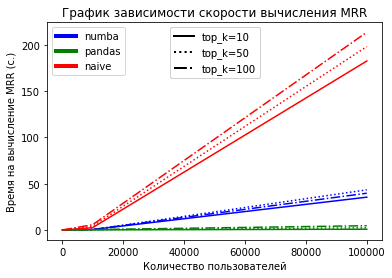

In [27]:
fig, ax = plt.subplots()
for i, method_durations in enumerate(total_mrr_durations):
    for j, top_k_durations in enumerate(method_durations):
        ax.plot(users_count, top_k_durations, linestyle=linestyles[j], color=colors[i])
color_legend = ax.legend(handles=color_lines, labels=['numba', 'pandas', 'naive'], loc='upper left')
style_legend = ax.legend(handles=style_lines, labels=[f"top_k={k}" for k in top_k], loc='upper center')
ax.add_artist(color_legend)
ax.add_artist(style_legend)
ax.set_title("График зависимости скорости вычисления MRR")
ax.set_xlabel("Количество пользователей")
ax.set_ylabel("Время на вычисление MRR (с.)")
plt.show()